In [41]:
import numpy as np
import cvxopt
import struct
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import matplotlib.cm as cmx
import matplotlib.colors as colors

## With obstacles

In [ ]:
del_t = 0.1
planning_horizon = 20
control_horizon = 5
# vx_guess = 10*np.ones((planning_horizon))
# vy_guess = 10*np.ones((planning_horizon))
# w_guess = 0.2*np.ones((planning_horizon))
vx_guess = np.random.randint(10, size=(planning_horizon))
vy_guess = np.random.randint(10, size=(planning_horizon))
print (vx_guess,vy_guess)
# w_guess = np.random.randint(0.1, size=(planning_horizon))
vx_init = vx_guess
vy_init = vy_guess
obst_rad = [2,3,4]
obst_dims = [6,8]
rad = [np.sqrt(obst_dims[0]**2+obst_dims[1]**2)/2 ]
print ("Object radius: ",rad)
obst_pos = [[20,40],[60,50],[80,80]]
# obst_pos = [[40,80]]

class multi_mpc_agent:
    def __init__(self,rad,start,goal,vxmax,vymax):
        self.rad = rad
        self.x = obst_dims[0]
        self.y = obst_dims[1]
        self.obst_rad = obst_rad
        self.obst = obst_pos
        self.xpath = []
        self.ypath = []
        self.vxplot = []
        self.vyplot = []
        self.time = 0
        self.goal = goal
        self.vx = vx_init
        self.vy = vy_init
        self.vx_guess = vx_guess
        self.vy_guess = vy_guess
        self.prev_vx = vx_guess
        self.prev_vy = vy_guess
        self.pos = start
        self.vxmax = vxmax
        self.vymax = vymax
        
        plt.ion()
        self.dummy_x = np.array([])
        self.dummy_y = np.array([])
        self.vxlast = self.vx_guess[0]
        self.vylast = self.vy_guess[0]
        self.vxlist = []
        self.vylist = []
        
    def __str__(self):
        return (str(self.time)+" "+str(self.pos))    
            
    def p_constructor(self):
#         nterms = planning_horizon*(planning_horizon-1)//2
        A = np.ones((planning_horizon,1))
        P = 2*del_t**2*np.matmul(A,A.T)
        net_P = np.kron(np.eye(2),P)
        q_gen = 2*del_t*A
        return net_P,q_gen
    
    def obst_constraint(self,i,ob):
        x_g = self.pos[0]+np.sum(self.vx_guess[:i]*del_t)
        y_g = self.pos[1]+np.sum(self.vy_guess[:i]*del_t)
        A = np.concatenate((np.ones((i,1)),np.zeros((planning_horizon-i,1))),axis=0)
#         x_g = self.pos[0]+np.matmul(A.T,self.vx_guess)
#         y_g = self.pos[1]+np.matmul(A.T,self.vy_guess)
        f_0 = (x_g-self.obst[ob][0])**2+(y_g-self.obst[ob][1])**2
        coeffx = 2*(x_g-self.obst[ob][0])*del_t
        coeffy = 2*(y_g-self.obst[ob][1])*del_t
        c_0 = -np.sum(coeffx*self.vx_guess[:i] + coeffy*self.vy_guess[:i])
        gx_term = coeffx*A
        gy_term = coeffy*A
        g_term = np.concatenate((gx_term,gy_term),axis=0)
#         print (g_term)
        net_constant = (f_0-c_0)
#         print (g_term.shape)
        return g_term,f_0,c_0
   
    def is_pos_def(self,x):
        return np.all(np.linalg.eigvals(x) >= 0)

    def opt_traj(self):
        self.visualize_traj()
        print ("start vx: ",self.vx,"start vy: ",self.vy)
        
        while (np.linalg.norm(self.pos-self.goal)>0.6):
            vx_new = self.vx
            vy_new = self.vy
            diff_vx = 999
            diff_vy = 999
            tol = 1e-1
            
            while (np.linalg.norm(np.array([diff_vy,diff_vx])**2)>tol):
                P,q = self.p_constructor()
                P += 1e-6*np.eye(P.shape[0])
    #                 print (P)
                q = np.concatenate(((self.pos[0]-self.goal[0])*q,(self.pos[1]-self.goal[1])*q),axis=0)
    #                 print (P,q)
                P = cvxopt.matrix(P,tc='d')
                q = cvxopt.matrix(q,tc='d')
                g_mat = np.eye(2*planning_horizon)
                g_mat = np.concatenate((g_mat,-np.eye(2*planning_horizon)),axis=0)
                g_mat = np.concatenate((g_mat,np.eye(2*planning_horizon)),axis=0)
                g_mat = np.concatenate((g_mat,-np.eye(2*planning_horizon)),axis=0)
                h_mat = np.concatenate((self.vxmax*np.ones(planning_horizon),
                                        self.vymax*np.ones(planning_horizon),
                                        np.zeros(planning_horizon),np.zeros(planning_horizon),
                                        self.vx_guess+5,self.vy_guess+5,-(self.vx_guess-5),
                                        -(self.vy_guess-5)),axis=None)
#                 h_mat = np.concatenate((self.vxmax*np.ones(planning_horizon),
#                                         self.vymax*np.ones(planning_horizon),
#                                         np.zeros(planning_horizon),np.zeros(planning_horizon)),axis=None)
                ##For collision avoidance
#                 print (self.pos[0]-self.obst[0],self.pos[1]-self.obst[1])
                for ob in range(len(self.obst)):
                    if (np.linalg.norm(np.array(self.pos)-np.array(self.obst[ob]))<20):
                        print ("I'm checking for collision")
                        for i in range(planning_horizon):
                            gterm,cons,obst_con = self.obst_constraint(i+1,ob)
                            g_mat = np.concatenate((g_mat,-gterm.T),axis=0)
                            padding = 2
                            rhs = -(-cons+(self.obst_rad[ob]+self.rad+2)**2+0.5-obst_con)
    #                         h_mat = np.append(h_mat, rhs)
                            h_mat = np.concatenate((h_mat,rhs),axis=None)
#                     print (g_mat)
                h = cvxopt.matrix(h_mat,tc='d')
                g = cvxopt.matrix(g_mat,tc='d')
                init_vals = np.concatenate((self.vx_guess,self.vy_guess),axis=None)
                sol = cvxopt.solvers.qp(P,q,g,h,options={'show_progress': False})
                vx_new = sol['x'][:planning_horizon] #vx
                vy_new = sol['x'][planning_horizon:] #vy
#                 print ("Optimizer op:",vx_new,vy_new)
#                 print ("Opti going on...")
                diff_vx = np.linalg.norm(np.array(vx_new) - self.vx)
                diff_vy = np.linalg.norm(np.array(vy_new) - self.vy)
#                 print (diff_v,diff_w)
                self.vx = vx_new
                self.vy = vy_new
                self.prev_vx = np.array(vx_new)
                self.prev_vy = np.array(vy_new)
#                 print (self.v,self.w)
                
                self.vx_guess = self.prev_vx
                self.vx_guess = self.vx_guess.reshape((-1,))
                self.vy_guess = self.prev_vy
                self.vy_guess = self.vy_guess.reshape((-1,))
            
                
            print ("##########End of Optimization#############")
            print ("Opti complete")
        
            dummy_x = []
            dummy_y = []
            temp_x = self.pos[0]
            temp_y = self.pos[1]
            for i in range(planning_horizon):
                temp_x = temp_x + self.vx[i]*del_t
                temp_y = temp_y + self.vy[i]*del_t
                dummy_x.append(temp_x)
                dummy_y.append(temp_y)

            self.dummy_x = np.array(dummy_x)
            self.dummy_y = np.array(dummy_y)
            
            for i in range(control_horizon):
                x_new = self.pos[0] + self.vx[i]*del_t
                y_new = self.pos[1] + self.vy[i]*del_t
                self.vxlist.append(self.vx[i])
                self.vylist.append(self.vy[i])
                self.xpath.append(x_new)
                self.ypath.append(y_new)
                self.pos = [x_new,y_new]
                print (self)
                self.time+=1
                self.visualize_traj()
            self.vxlast = self.vx[control_horizon-1]
            self.vylast = self.vy[control_horizon-1]
            print ("#####End of control horizon#####")
            self.vx_guess = self.vx[control_horizon:planning_horizon]
            self.vx_guess = np.concatenate((self.vx_guess,self.vx[planning_horizon-1]*np.ones([control_horizon,1])),axis=0)
            self.vx_guess = self.vx_guess.reshape((-1,))
            self.vy_guess = self.vy[control_horizon:planning_horizon]
            self.vy_guess = np.concatenate((self.vy_guess,self.vy[planning_horizon-1]*np.ones([control_horizon,1])),axis=0)
            self.vy_guess = self.vy_guess.reshape((-1,))
            
        plt.figure()
        plt.plot(self.vxlist)
        plt.show()
        plt.figure()
        plt.plot(self.vylist)
                

             
    def visualize_traj(self):
        figure = plt.figure()
        ax = figure.add_subplot(1,1,1)
        # robot = matplotlib.patches.Circle(
        #     (self.pos[0],self.pos[1]),
        #     radius = self.rad,
        #     edgecolor='black',
        #     facecolor='pink',
        #     linewidth=1.0,
        #     ls='solid',
        #     alpha=1,
        #     zorder=2)

        # add rectangular patch for robot using object_dims
        robot = matplotlib.patches.Rectangle(
            (self.pos[0]-self.rad/2,self.pos[1]-self.rad/2),
            self.x,
            self.y,
            edgecolor='black',
            facecolor='pink',
            linewidth=1.0,
            ls='solid',
            alpha=1,
            zorder=2)
        
        for i in range(len(self.obst)):
            obst = matplotlib.patches.Circle(
                (self.obst[i][0],self.obst[i][1]),
                radius = self.obst_rad[i],
                edgecolor='black',
                linewidth=1.0,
                ls='solid',
                alpha=1,
                zorder=2)
            ax.add_patch(obst)
        ax.plot([self.goal[0]], [self.goal[1]], '*', color="yellow", markersize =15,linewidth=3.0, zorder=1)
        ax.add_patch(robot)
        name = 'data/snap%s.png'%str(self.time)
        ax.plot(self.xpath,self.ypath,'g-')
        ax.plot(self.dummy_x, self.dummy_y, 'r--')
#         ax.plot(self.prev_v,self.ypath,'b-')
        ax.set_aspect('equal')
        ax.set_xlim(-10.0, 150.0)
        ax.set_ylim(-10.0, 150.0)
        ax.set_xlabel(r'$x (m)$')
        ax.set_ylabel(r'$y (m)$')
        ax.grid(True)
        plt.savefig(name, dpi = 200)
        plt.cla()
        plt.close(figure)
        return figure

[2 1 8 6 7 2 6 5 7 2 0 8 5 0 3 9 7 3 3 3] [0 4 7 5 0 8 2 0 3 8 7 7 4 4 1 3 7 0 6 8]
Object radius:  [np.float64(5.0)]


start vx:  [2 1 8 6 7 2 6 5 7 2 0 8 5 0 3 9 7 3 3 3] start vy:  [0 4 7 5 0 8 2 0 3 8 7 7 4 4 1 3 7 0 6 8]
##########End of Optimization#############
Opti complete
0 [np.float64(10.999999989805142), np.float64(20.999999988027028)]
1 [np.float64(11.999999979610283), np.float64(21.999999976054053)]
2 [np.float64(12.999999969415425), np.float64(22.999999964081077)]
3 [np.float64(13.999999959220567), np.float64(23.9999999521081)]
4 [np.float64(14.999999949025709), np.float64(24.999999940135126)]
#####End of control horizon#####
I'm checking for collision
I'm checking for collision
I'm checking for collision
I'm checking for collision
##########End of Optimization#############
Opti complete
5 [np.float64(15.999999938685953), np.float64(25.6554841018286)]
6 [np.float64(16.99999992857083), np.float64(26.120451171300097)]
7 [np.float64(17.99999991827899), np.float64(26.639719075657613)]
8 [np.float64(18.999999907976502), np.float64(27.099801657775274)]
9 [np.float64(19.99999989761781), np.float

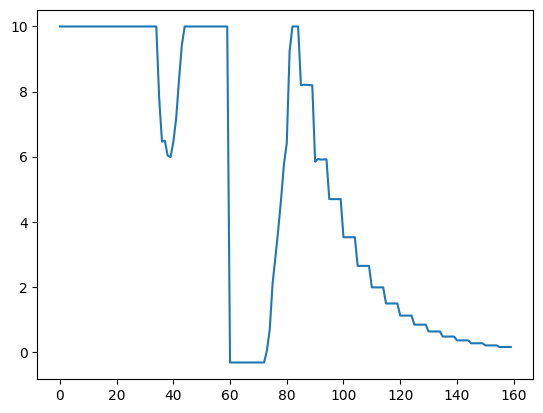

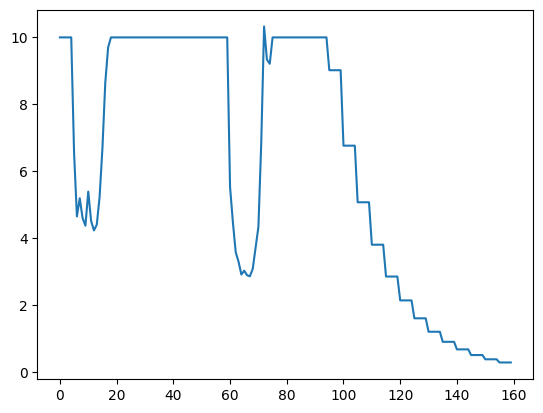

In [43]:
bot2 = multi_mpc_agent(rad[0],np.array([10,20]),np.array([90,120]),10,10)
bot2.opt_traj()